In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

from amlvae.models.VAE import VAE
from sklearn.metrics import r2_score 
from matplotlib import pyplot as plt

import os
import tempfile

from ray.tune import Checkpoint
import pandas as pd 

from scipy.stats import spearmanr
import seaborn as sbn

from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

import umap 

from amlvae.train.Trainer import Trainer


In [2]:
# alpha	    batch_size	beta	dropout	    l2	    lr	        n_hidden	n_latent	n_layers	nonlin	norm	    variational	    iter	total time (s)	    val_mse
# 0	        256	        0.01	0.3	        1e-06	0.0001	    512	        12	        1	        gelu	batch	    True	        1000	18.6734	            0.439466 
# 0	        32	        0.5	    0.1	        0.0001	0.0001	    128	        12	        1	        gelu	none	    False	        1000	75.6988	            0.436909

In [ ]:
trainer = Trainer(
    root='/home/teddy/local/AMLVAE/data/',
    checkpoint=True,
    epochs=1000,
    verbose=False, 
    patience=100
)


search_space = {
    "lr": hp.choice('lr', [5e-5, 1e-4, 5e-4]),
    "l2": hp.choice('l2', [0, 1e-6, 1e-2]),
    "n_hidden": hp.choice('n_hidden', [256, 512, 1024, 2048]),
    "n_latent": hp.choice('n_latent', [12]),
    "n_layers": hp.choice('n_layers', [1, 2, 4]),
    "batch_size": hp.choice('batch_size', [128, 256]),
    "aggresive_updates": hp.choice('aggresive_updates', [True, False]),
    "norm": hp.choice('norm', ["batch", "layer", "none"]),
    "variational": hp.choice('variational', [True]),
    "anneal": hp.choice('anneal', [True, False]),
    "dropout": hp.choice('dropout', [0.0, 0.1, 0.2, 0.3]),
    "nonlin": hp.choice('nonlin', ["elu", "gelu"]),
    "alpha": hp.choice('alpha', [0]),
    "beta": hp.choice('beta', [0, 1e-2, 5e-2, 1e-1, 5e-1, 1]),
}

hyperopt_search = HyperOptSearch(search_space, metric="val_mse", mode="min", )

tuner = tune.Tuner(
    tune.with_resources(trainer, {"cpu":10, "gpu": 1}),
    tune_config=tune.TuneConfig(num_samples=250, 
                                search_alg=hyperopt_search
    ), 
)
results = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (13 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(raylet) [2025-05-02 13:29:21,402 E 11471 11503] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-05-02_13-29-09_691791_11187 is over 95% full, available space: 13.4461 GB; capacity: 491.084 GB. Object creation will fail if spilling is required.
(raylet) [2025-05-02 13:29:31,417 E 11471 11503] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-05-02_13-29-09_691791_11187 is over 95% full, available space: 13.446 GB; capacity: 491.084 GB. Object creation will fail if spilling is required.
(raylet) [2025-05-02 13:29:41,435 E 11471 11503] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-05-02_13-29-09_691791_11187 is over 95% full, available space: 13.446 GB; capacity: 491.084 GB. Object creation will fail if spilling is required.
(raylet) [2025-05-02 13:29:51,454 E 11471 11503] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-05-02_13-29-09_691791_11187 is over 95% full, available space: 13.4459 GB; capacity: 491.084 GB. Object creation will fail if 

In [ ]:
dfs = {result.path: result.metrics_dataframe for result in results}

ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_mse.plot(ax=ax, legend=False)

plt.ylim(0.4, 0.6)

NameError: name 'results' is not defined

: 

In [ ]:
dfs = {result.path: result.metrics_dataframe for result in results}

res = {'val_mse': [], 'val_r2':[], 'val_elbo':[], 'batch_size': [], 'beta': [], 'dropout': [], 'l2': [], 'lr': [], 'n_hidden': [], 'n_latent': [], 'n_layers': [], 'nonlin': [], 'norm': [], 'variational': [], 'n_epochs': [], 'path':[]}
for name, df in dfs.items():
    best_trial = df.loc[df.val_mse.idxmin()]
    res['val_mse'].append(best_trial.val_mse)
    res['val_r2'].append(best_trial.val_r2)
    res['val_elbo'].append(best_trial.val_elbo)
    res['batch_size'].append(best_trial['config/batch_size'])
    res['beta'].append(best_trial['config/beta'])
    res['dropout'].append(best_trial['config/dropout'])
    res['l2'].append(best_trial['config/l2'])
    res['lr'].append(best_trial['config/lr'])
    res['n_hidden'].append(best_trial['config/n_hidden'])
    res['n_latent'].append(best_trial['config/n_latent'])
    res['n_layers'].append(best_trial['config/n_layers'])
    res['nonlin'].append(best_trial['config/nonlin'])
    res['norm'].append(best_trial['config/norm'])
    res['variational'].append(best_trial['config/variational'])
    res['n_epochs'].append(best_trial['training_iteration'])
    res['path'].append(name)

res = pd.DataFrame(res).sort_values(by='val_mse', ascending=True).reset_index(drop=True)
res.head().style.hide() 
    

val_mse,batch_size,beta,dropout,l2,lr,n_hidden,n_latent,n_layers,nonlin,norm,variational,n_epochs,path
0.690002,256,1.000000,0.100000,0.000100,0.000100,512,12,1,elu,batch,True,972,"/home/teddy/ray_results/train_fn_2025-04-24_16-55-16/train_fn_200a08de_70_alpha=0,batch_size=256,beta=1,dropout=0.1000,l2=0.0001,lr=0.0001,n_hidden=512,n_latent=12,n_layers=1,nonlin=e_2025-04-24_17-52-43"
0.690232,256,1.000000,0.100000,0.000100,0.000100,512,12,1,elu,batch,True,942,"/home/teddy/ray_results/train_fn_2025-04-24_16-55-16/train_fn_c7b62082_67_alpha=0,batch_size=256,beta=1,dropout=0.1000,l2=0.0001,lr=0.0001,n_hidden=512,n_latent=12,n_layers=1,nonlin=e_2025-04-24_17-51-31"
0.691648,256,0.100000,0.100000,0.000000,0.000500,512,12,1,elu,batch,True,197,"/home/teddy/ray_results/train_fn_2025-04-24_16-55-16/train_fn_5bc25330_106_alpha=0,batch_size=256,beta=0.1000,dropout=0.1000,l2=0.0000,lr=0.0005,n_hidden=512,n_latent=12,n_layers=1,no_2025-04-24_18-15-59"
0.691776,256,1.000000,0.100000,0.000100,0.000100,512,12,1,elu,batch,True,696,"/home/teddy/ray_results/train_fn_2025-04-24_16-55-16/train_fn_03f58413_71_alpha=0,batch_size=256,beta=1,dropout=0.1000,l2=0.0001,lr=0.0001,n_hidden=512,n_latent=12,n_layers=1,nonlin=e_2025-04-24_17-53-09"
0.693372,256,0.010000,0.100000,0.000100,0.000100,512,12,1,elu,batch,True,618,"/home/teddy/ray_results/train_fn_2025-04-24_16-55-16/train_fn_71857ed9_82_alpha=0,batch_size=256,beta=0.0100,dropout=0.1000,l2=0.0001,lr=0.0001,n_hidden=512,n_latent=12,n_layers=1,non_2025-04-24_17-57-48"


In [ ]:
idx = 1

model = VAE(
    input_dim=2500,
    hidden_dims=[512],
    latent_dim=12,
    norm='batch',
    variational=True,
    dropout=0.1,
    nonlin='elu',
    alpha=0,
)
model.load_state_dict(torch.load('/home/teddy/ray_results/train_fn_2025-04-24_16-55-16/train_fn_200a08de_70_alpha=0,batch_size=256,beta=1,dropout=0.1000,l2=0.0001,lr=0.0001,n_hidden=512,n_latent=12,n_layers=1,nonlin=e_2025-04-24_17-52-43' + '/checkpoint_000003/model.pth', weights_only=True))
model = model.eval()

torch.save(model, '../output/vae_l12_4-24-25.pt')

In [ ]:
data = pd.read_csv('/home/teddy/local/AMLVAE/data/aml_expr.csv')
data = data.set_index(data.columns[0])
partitions = torch.load('/home/teddy/local/AMLVAE/data/aml_partitions.pt', weights_only=False)

X_train = torch.tensor( 
    data.loc[partitions['train_ids'], :].values, dtype=torch.float32
)
X_val = torch.tensor(
    data.loc[partitions['val_ids'], :].values, dtype=torch.float32
)
X_test = torch.tensor(
    data.loc[partitions['test_ids'], :].values, dtype=torch.float32
)

In [ ]:
xhat_train = model.predict(X_train)
xhat_val = model.predict(X_val)
xhat_test = model.predict(X_test)

train_mse = F.mse_loss(xhat_train, X_train).item()
val_mse = F.mse_loss(xhat_val, X_val).item()
test_mse = F.mse_loss(xhat_test, X_test).item()

train_r2 = r2_score(X_train.detach().cpu().numpy(), xhat_train.detach().cpu().numpy(), multioutput='uniform_average')
val_r2 = r2_score(X_val.detach().cpu().numpy(), xhat_val.detach().cpu().numpy(), multioutput='uniform_average')
test_r2 = r2_score(X_test.detach().cpu().numpy(), xhat_test.detach().cpu().numpy(), multioutput='uniform_average')

print(f'Train MSE: {train_mse:.4f}')
print(f'Validation MSE: {val_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print()
print(f'Train R2: {train_r2:.4f}')
print(f'Validation R2: {val_r2:.4f}')
print(f'Test R2: {test_r2:.4f}')

Train MSE: 0.2192
Validation MSE: 0.6914
Test MSE: 0.3953

Train R2: 0.7803
Validation R2: 0.0223
Test R2: 0.6167


In [ ]:
from sklearn.decomposition import PCA

reducer = PCA(n_components=12)

# git mse from pca 
pca = PCA(n_components=12)
pca.fit(X_train.detach().cpu().numpy())

xhat_train = pca.inverse_transform(pca.transform(X_train.detach().cpu().numpy()))
xhat_val = pca.inverse_transform(pca.transform(X_val.detach().cpu().numpy()))
xhat_test = pca.inverse_transform(pca.transform(X_test.detach().cpu().numpy()))

train_mse = F.mse_loss(torch.tensor(xhat_train), X_train).item()
val_mse = F.mse_loss(torch.tensor(xhat_val), X_val).item()
test_mse = F.mse_loss(torch.tensor(xhat_test), X_test).item()

train_r2 = r2_score(X_train.detach().cpu().numpy(), xhat_train, multioutput='uniform_average')
val_r2 = r2_score(X_val.detach().cpu().numpy(), xhat_val, multioutput='uniform_average')
test_r2 = r2_score(X_test.detach().cpu().numpy(), xhat_test, multioutput='uniform_average')

print('######## PCA ########')
print(f'Train MSE: {train_mse:.4f}')
print(f'Validation MSE: {val_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print()
print(f'Train R2: {train_r2:.4f}')
print(f'Validation R2: {val_r2:.4f}')
print(f'Test R2: {test_r2:.4f}')

######## PCA ########
Train MSE: 0.3631
Validation MSE: 0.7456
Test MSE: 0.4265

Train R2: 0.6362
Validation R2: -0.0500
Test R2: 0.5875


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


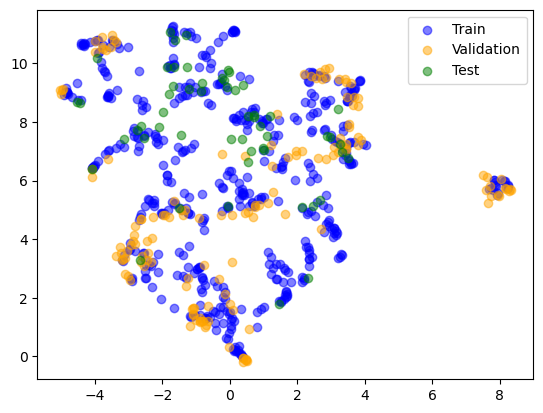

In [ ]:
z_train, _  = model.encode(X_train) 
z_val, _  = model.encode(X_val)
z_test, _  = model.encode(X_test)

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.1, metric='cosine')
u_train = reducer.fit_transform(z_train.detach().cpu().numpy())
u_val = reducer.transform(z_val.detach().cpu().numpy())
u_test = reducer.transform(z_test.detach().cpu().numpy())

plt.figure() 
plt.scatter(u_train[:, 0], u_train[:, 1], c='blue', label='Train', alpha=0.5)
plt.scatter(u_val[:, 0], u_val[:, 1], c='orange', label='Validation', alpha=0.5)
plt.scatter(u_test[:, 0], u_test[:, 1], c='green', label='Test', alpha=0.5)
plt.legend() 
plt.show()

In [ ]:
clin = pd.read_csv('../../data/beataml_clinical_for_inputs.csv')

In [ ]:
dff = pd.DataFrame(torch.cat([z_train, z_val, z_test], dim=0).detach().cpu().numpy()).assign(gdc_id=np.concatenate([partitions['train_ids'], partitions['val_ids'], partitions['test_ids']]))
dff = dff.merge(clin, how='left', left_on='gdc_id', right_on='gdc_id').assign(u1=np.concatenate([u_train[:, 0], u_val[:, 0], u_test[:, 0]]), u2=np.concatenate([u_train[:, 1], u_val[:, 1], u_test[:, 1]]))
dff.head()

,0,1,2,3,4,5,6,7,8,9,...,priorMDS,FLT3-ITD,allelic_ratio,NPM1,RUNX1,ASXL1,TP53,ELN2017,u1,u2
0,0.264219,-1.878966,0.406054,1.991063,1.630960,1.486910,1.955832,-4.791457,1.555816,1.286854,...,n,positive,1.000000,negative,NaN,NaN,NaN,Adverse,-2.398885,3.129192
1,-2.055761,-3.024253,-0.126599,2.928538,3.619126,-0.724510,-1.724527,-4.809821,2.060803,-2.485082,...,n,positive,0.449275,negative,RUNX1 (p.Q262*; 72.4%),NaN,NaN,Adverse,-2.491185,2.691542
2,0.870613,-1.249609,-0.125173,1.646526,-0.084758,-1.328353,1.874736,0.475747,2.588633,0.138885,...,n,negative,0.000000,positive,NaN,NaN,NaN,Favorable,-1.181747,1.393467
3,-0.173579,0.509097,-1.303566,-2.137247,0.418065,-1.378598,-7.102830,-1.085725,1.118503,0.382167,...,n,negative,0.000000,negative,NaN,NaN,NaN,NonInitial,-2.712545,7.678674
4,3.082670,-3.504873,2.560643,0.599412,-0.020471,1.023845,1.704931,1.891255,-3.983865,-4.622263,...,n,negative,0.000000,positive,NaN,NaN,NaN,Favorable,0.086214,6.089407


In [ ]:
fbms = dff.fabBlastMorphology.dropna().unique() 
rs = np.zeros((len(fbms), 12))
ps = np.zeros((len(fbms), 12))
for j, f in enumerate(fbms):
    x = 1.*(dff.fabBlastMorphology == f)
    for i in range(12):
        rs[j, i], ps[j, i] = spearmanr(x, dff[i])

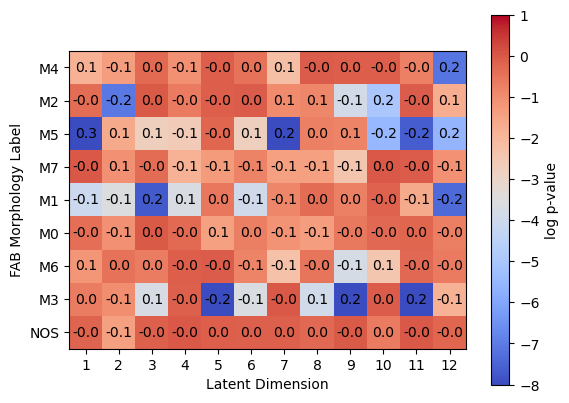

In [ ]:
plt.figure() 
# plot color map in log scale 
ps_log = np.log10(ps)
plt.imshow(ps_log, cmap='coolwarm', vmin=-8, vmax=1, )

for i in range(len(fbms)):
    for j in range(12):
        plt.text(j, i, f'{rs[i, j]:.1f}', ha='center', va='center', color='black')

# add color bar with label 
cbar = plt.colorbar()
# add color bar label 
cbar.set_label('log p-value')

plt.xticks(np.arange(12), np.arange(1, 13))
plt.yticks(np.arange(len(fbms)), fbms)
plt.xlabel('Latent Dimension')
plt.ylabel('FAB Morphology Label')
plt.show()

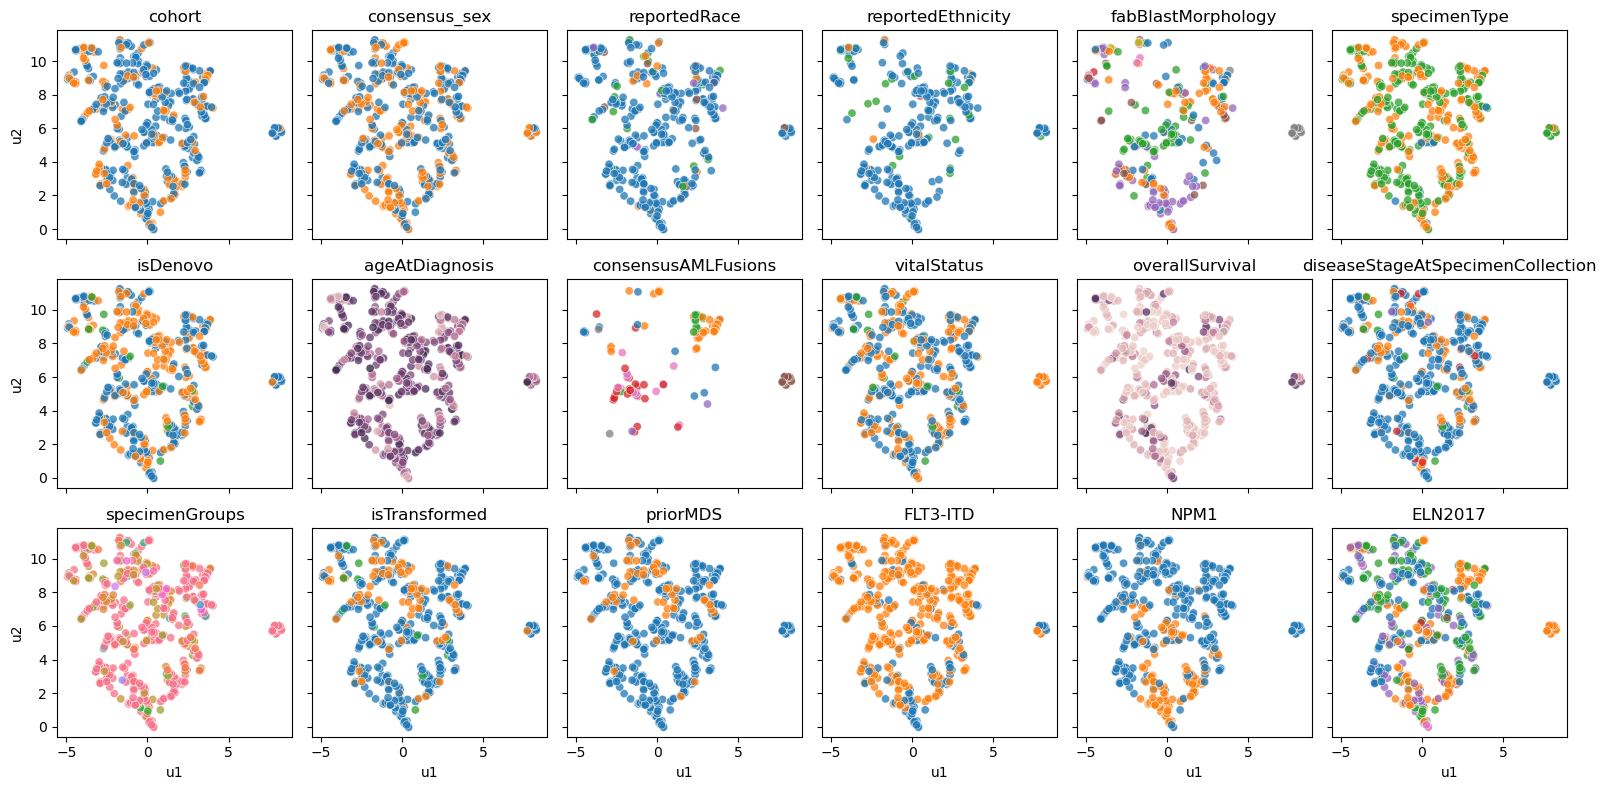

In [ ]:
f,axes = plt.subplots(3,6, figsize=(16, 8), sharex=True, sharey=True)

for i,c in enumerate(['cohort', 'consensus_sex',
       'reportedRace', 'reportedEthnicity', 'fabBlastMorphology',
       'specimenType', 'isDenovo', 'ageAtDiagnosis', 'consensusAMLFusions',  'vitalStatus', 'overallSurvival',
       'diseaseStageAtSpecimenCollection', 'specimenGroups',
       'isTransformed', 'priorMDS', 'FLT3-ITD', 'NPM1', 'ELN2017']): 

    sbn.scatterplot(x='u1', y='u2', hue=c, data=dff, alpha=0.75, ax=axes.flatten()[i], legend=False)
    axes.flatten()[i].set_title(c)

plt.tight_layout()
plt.show() 